In [1]:
import pandas as pd
import numpy as np
import sqlite3

In [2]:
con = sqlite3.connect('../data/imdb/im.db')

In [3]:
imdb_schema = pd.read_sql("""

SELECT *
FROM sqlite_master

""", con)
imdb_schema

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [4]:
rating_info_comb_5k = pd.read_sql("""

SELECT *
FROM movie_basics AS b
    JOIN movie_ratings AS r
        ON b.movie_id = r.movie_id
WHERE numvotes > 5000

""", con)

In [5]:
tn_movie_budgets_df = pd.read_csv("../Data/tn.movie_budgets.csv")
tn_movie_budgets_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [6]:
rating_info_comb_5k.rename(columns={'primary_title':'movie'}, inplace=True)

In [7]:
info_budget_df = pd.merge(rating_info_comb_5k, tn_movie_budgets_df, on='movie')

In [8]:
info_budget_df["production_budget"] = info_budget_df["production_budget"].replace('[\$,]', '', regex=True).astype(int)

In [9]:
info_budget_df["domestic_gross"] = info_budget_df["domestic_gross"].replace('[\$,]', '', regex=True).astype(int)

In [10]:
info_budget_df["worldwide_gross"] = info_budget_df["worldwide_gross"].replace('[\$,]', '', regex=True).astype(int)

In [11]:
info_budget_df['net_revenue'] = info_budget_df["worldwide_gross"] - info_budget_df["production_budget"]

In [12]:
info_budget_df['ROI%'] = info_budget_df['net_revenue'] / info_budget_df["production_budget"]

In [13]:
info_budget_df.drop(columns=['movie_id', 'original_title', 'id', 'start_year', 'release_date'], inplace=True)

In [14]:
info_budget_df.columns

Index(['movie', 'runtime_minutes', 'genres', 'averagerating', 'numvotes',
       'production_budget', 'domestic_gross', 'worldwide_gross', 'net_revenue',
       'ROI%'],
      dtype='object')

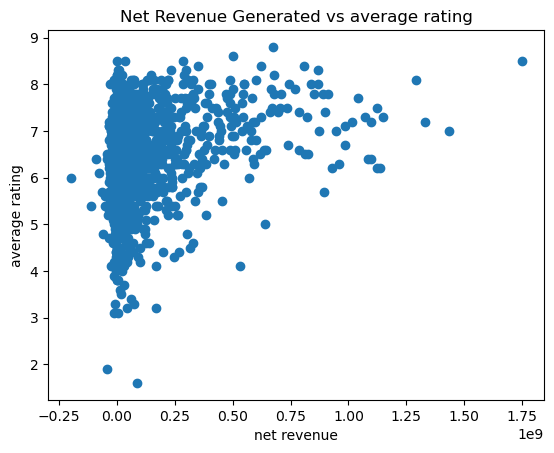

In [15]:
import matplotlib.pyplot as plt

plt.scatter(info_budget_df['net_revenue'], info_budget_df['averagerating'])
plt.title('Net Revenue Generated vs average rating')
plt.xlabel('net revenue')
plt.ylabel('average rating')
plt.show()

In [16]:
all_genres = info_budget_df['genres'].str.split(',').explode()
unique_genres = all_genres.unique()
unique_genres

array(['Action', 'Adventure', 'Fantasy', 'Comedy', 'Biography', 'Drama',
       'Sport', 'Romance', 'Crime', 'Horror', 'Thriller', 'Family',
       'Sci-Fi', 'Mystery', 'History', 'Animation', 'Documentary', 'War',
       'Music', 'Musical', 'Western'], dtype=object)

In [17]:
def create_genre_dataframe(df, genre):
    """
    Creates a dataframe containing only the rows where the specified genre is one of the genres.

    :param df: The original dataframe with movie data.
    :param genre: The genre to filter by.
    :return: A dataframe containing only rows with the specified genre.
    """
    # Filter rows where the genre column contains the specified genre
    genre_df = df[df['genres'].astype(str).str.contains(genre, na=False)]
    return genre_df

In [18]:
horror_df = create_genre_dataframe(info_budget_df, 'Horror')
action_df = create_genre_dataframe(info_budget_df, 'Action')
adventure_df = create_genre_dataframe(info_budget_df, 'Adventure')
fantasy_df = create_genre_dataframe(info_budget_df, 'Fantasy')
scifi_df = create_genre_dataframe(info_budget_df, 'Sci-Fi')
thriller_df = create_genre_dataframe(info_budget_df, 'Thriller')
western_df = create_genre_dataframe(info_budget_df, 'Western')
animation_df = create_genre_dataframe(info_budget_df, 'Animation')
comedy_df = create_genre_dataframe(info_budget_df, 'Comedy')
family_df = create_genre_dataframe(info_budget_df, 'Family')
crime_df = create_genre_dataframe(info_budget_df, 'Crime')
drama_df = create_genre_dataframe(info_budget_df, 'Drama')
romance_df = create_genre_dataframe(info_budget_df, 'Romance')
mystery_df = create_genre_dataframe(info_budget_df, 'Mystery')
history_df = create_genre_dataframe(info_budget_df, 'History')
sports_df = create_genre_dataframe(info_budget_df, 'Sport')
biography_df = create_genre_dataframe(info_budget_df, 'Biography')
war_df = create_genre_dataframe(info_budget_df, 'War')
musical_df = create_genre_dataframe(info_budget_df, 'Musical')
documentary_df = create_genre_dataframe(info_budget_df, 'Documentary')
music_df = create_genre_dataframe(info_budget_df, 'Music')
news_df = create_genre_dataframe(info_budget_df, 'News')

In [19]:
genre_df_dict = {'Horror': horror_df, 'Action': action_df, 'Adventure': adventure_df, 'Fantasy': fantasy_df, 'Sci-Fi': scifi_df, 'Thriller': thriller_df,
       'Western': western_df, 'Animation': animation_df, 'Comedy': comedy_df, 'Family': family_df, 'Crime': crime_df, 'Drama': drama_df,
       'Romance': romance_df, 'Mystery': mystery_df, 'History': history_df, 'Sport': sports_df, 'Biography': biography_df, 'War': war_df,
       'Musical': musical_df, 'Documentary': documentary_df, 'Music': music_df, 'News': news_df}

In [20]:
genre_ROI_df_dict= {'Horror': horror_df['ROI%'], 'Action': action_df['ROI%'], 'Adventure': adventure_df['ROI%'], 
                    'Fantasy': fantasy_df['ROI%'], 'Sci-Fi': scifi_df['ROI%'], 'Thriller': thriller_df['ROI%'], 
                    'Western': western_df['ROI%'], 'Animation': animation_df['ROI%'], 'Comedy': comedy_df['ROI%'], 
                    'Family': family_df['ROI%'], 'Crime': crime_df['ROI%'],
                    'Drama': drama_df['ROI%'], 'Romance': romance_df['ROI%'], 'Mystery': mystery_df['ROI%'], 
                    'History': history_df['ROI%'], 'Sport': sports_df['ROI%'],
                    'Biography': biography_df['ROI%'], 'War': war_df['ROI%'], 'Musical': musical_df['ROI%'], 
                    'Documentary': documentary_df['ROI%'], 'Music': music_df['ROI%'], 'News': news_df['ROI%']}
len(genre_ROI_df_dict)

22

In [21]:
genre_count = [(genre, len(i)) for genre, i in genre_ROI_df_dict.items()]
genre_count.sort(key=lambda tup: tup[1], reverse=True)
top_15_genres = genre_count[:15]
top_15_genres

[('Drama', 781),
 ('Comedy', 519),
 ('Action', 463),
 ('Adventure', 376),
 ('Thriller', 289),
 ('Crime', 257),
 ('Romance', 197),
 ('Horror', 194),
 ('Sci-Fi', 154),
 ('Mystery', 145),
 ('Biography', 144),
 ('Fantasy', 138),
 ('Animation', 101),
 ('Family', 83),
 ('Music', 52)]

In [22]:
net_rev_df = pd.DataFrame(info_budget_df.groupby('movie').net_revenue.sum())

In [23]:
netrev_sorted_df = net_rev_df.sort_values('net_revenue', ascending=False)

In [35]:
netrev_sorted_df

,net_revenue
movie,
Beauty and the Beast,3375261676
Frozen,2244939820
Avengers: Infinity War,1748134200
Jurassic World,1433854864
Furious 7,1328722794
...,...
Shanghai,-68988156
The Promise,-79448583
Bright,-90000000


In [24]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [27]:
from scipy.stats import kruskal

In [37]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [71]:
for x, y in genre_ROI_df_dict.items():
    average_roi = y.mean()
    print(f'{x}: {average_roi}')

Horror: 10.367332285263508
Action: 1.896104994425012
Adventure: 2.472051211636257
Fantasy: 3.1589068437314607
Sci-Fi: 2.556884994761929
Thriller: 6.321463595902329
Western: 0.38193258119384244
Animation: 3.767128595985951
Comedy: 2.5953565143641764
Family: 3.67570416569923
Crime: 1.0745867244006921
Drama: 2.6168674546840474
Romance: 2.7815175597505566
Mystery: 8.870623388527429
History: 3.4815387361249446
Sport: 1.4537170051108703
Biography: 3.124754022086557
War: 0.7546614552406627
Musical: 6.377064738849367
Documentary: 2.348045606296915
Music: 3.5823715563441274
News: nan


In [69]:
import matplotlib.pyplot as plt

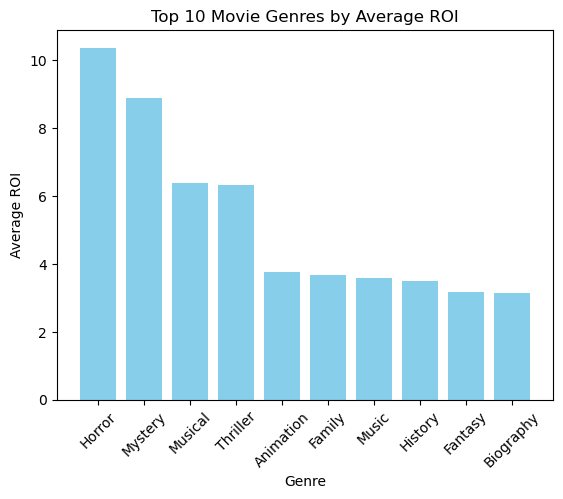

In [70]:
# Calculate the average ROI for each genre
genre_average_roi = {genre: df.mean() for genre, df in genre_ROI_df_dict.items()}

# Sort the genres by their average ROI in descending order and take the top 10
sorted_genre_average_roi = dict(sorted(genre_average_roi.items(), key=lambda item: item[1], reverse=True)[:10])

# Unpack the genres and their ROIs into separate lists
genres = list(sorted_genre_average_roi.keys())
average_rois = list(sorted_genre_average_roi.values())

# Create a bar chart
plt.figsize=(10, 6)
plt.bar(genres, average_rois, color='skyblue')
plt.xlabel('Genre')
plt.ylabel('Average ROI')
plt.title('Top 10 Movie Genres by Average ROI')
plt.xticks(rotation=45)
plt.show()

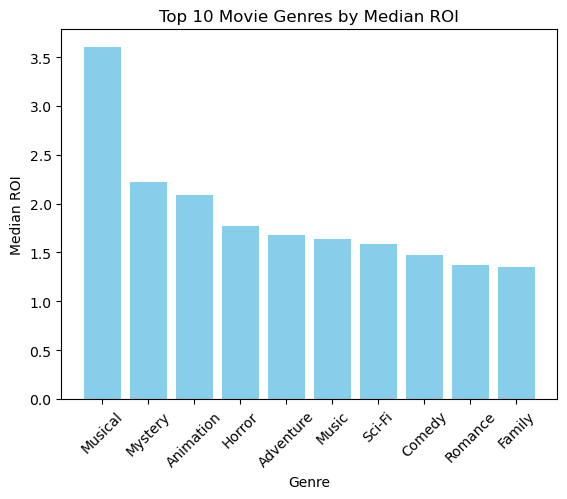

In [79]:
genre_median_roi = {genre: df.median() for genre, df in genre_ROI_df_dict.items()}
sorted_genre_median_roi = dict(sorted(genre_median_roi.items(), key=lambda item: item[1], reverse=True)[:10])
genres = list(sorted_genre_median_roi.keys())
median_rois = list(sorted_genre_median_roi.values())

# Create a bar chart
plt.figsize=(10, 6)
plt.bar(genres, median_rois, color='skyblue')
plt.xlabel('Genre')
plt.ylabel('Median ROI')
plt.title('Top 10 Movie Genres by Median ROI')
plt.xticks(rotation=45)
plt.show()

In [83]:
import seaborn as sns

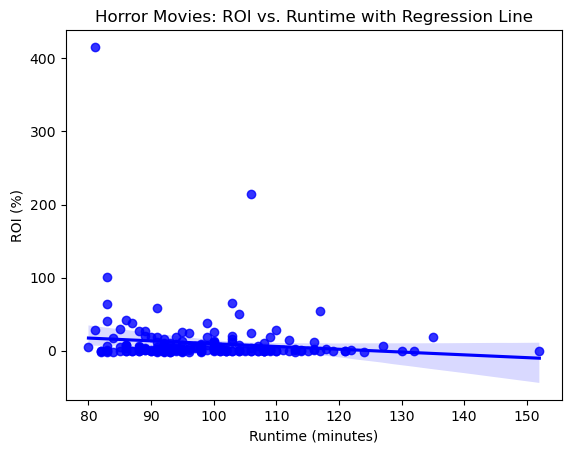

In [85]:
plt.figsize=(8, 6)
sns.regplot(x='runtime_minutes', y='ROI%', data=horror_df, color='blue')
plt.title('Horror Movies: ROI vs. Runtime with Regression Line')
plt.xlabel('Runtime (minutes)')
plt.ylabel('ROI (%)')
plt.show()

In [90]:
horror_df['ROI%'].quantile(0.25)

-0.24331026

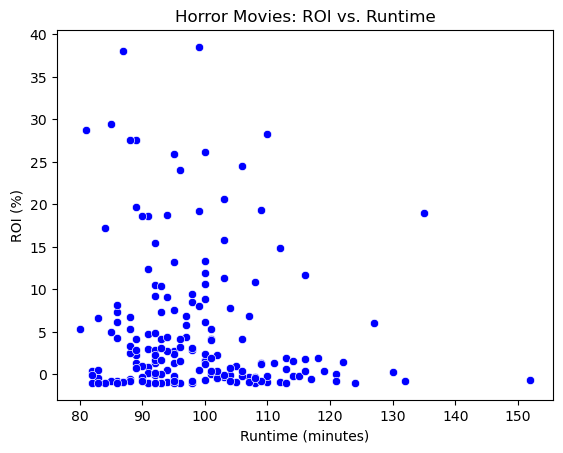

In [111]:
lower = horror_df['ROI%'].quantile(0.01)
upper = horror_df['ROI%'].quantile(0.95)

# Filter out the outliers
filtered_horror_df = horror_df[~((horror_df['ROI%'] < lower) | (horror_df['ROI%'] > upper))]

plt.figsize=(8, 6)
sns.scatterplot(x='runtime_minutes', y='ROI%', data=filtered_horror_df, color='blue')
plt.title('Horror Movies: ROI vs. Runtime')
plt.xlabel('Runtime (minutes)')
plt.ylabel('ROI (%)')
plt.show()

In [114]:
filtered_horror_df.to_csv('../Data/genre_test.csv')